In [1]:
# Imports
import wfdb
import matplotlib.pyplot as plt
from constants import *
from main import *
import h5py
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import shuffle

In [2]:
# Get all records

record_list = get_all_records(TRAIN_PATH, "RECORDS")
len(record_list)

994

In [23]:
def transform_undef(hypnogram):
    hypnogram[hypnogram == 0] = 5
    return hypnogram

def create_random_hypno(shape):
    return transform_undef(np.random.randint(6, size=(shape)))

def plot_hypnogram(hypnogram, name):
    plt.figure(figsize=(12, 3))
    plt.yticks(list(TICK_LABELS.keys()),
               list(TICK_LABELS.values()),
               size=12)
    plt.xlabel("epochs", size=12)
    plt.xticks(size=12)
    plt.title(name)
    plt.grid()
    plt.plot(hypnogram)
    plt.show()

def contingency_table(conf_mat):
    total = np.sum(conf_mat)
    total_rand = np.sum(conf_mat, axis=0)
    
    total_real = np.sum(conf_mat, axis=1)
    total_real = np.append(total_real, total)
    
    conf_mat = np.vstack((conf_mat, total_rand))
    
    return np.concatenate((conf_mat, total_real[:, None]), axis=1)


def get_mask(cont_table):
    # Default all sleep stages were reached 
    # len(cont_table) = 6
    my_mask = np.array([[False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [False,False,False,False,False,True],
                        [True,True,True,True,True,True]])
    if len(cont_table) == 5:
        my_mask = np.array([
            [False, False, False, False, True],
            [False, False, False, False, True],
            [False, False, False, False, True],
            [False, False, False, False, True],
            [True, True, True, True, True]])
        
    if len(cont_table) == 4:
        my_mask = np.array([
            [False, False, False, True],
            [False, False, False, True],
            [False, False, False, True],
            [True, True, True, True]])
        
    return my_mask

def plot_simple_cont_table(conf_mat, name):
    
    labels = ["N3","N2","N1","REM","WAKE","TOTAL"]
    
    cont_table = contingency_table(conf_mat)
    
    sns.heatmap(cont_table, cmap='YlOrRd', fmt="d", annot=True,
                yticklabels=labels, xticklabels=labels,
                mask=my_mask)
    sns.heatmap(cont_table, cmap='binary', fmt="d", annot=True,
                yticklabels=labels, xticklabels=labels, ax = ax,
                cbar=False, mask=~my_mask)
    
    ax.set_ylabel("real value")
    ax.set_xlabel("random value")
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    plt.title(name)
    plt.show()

def plot_contigency_table(hypnogram, random_hypnogram, name):
    labels = ["N3","N2","N1","REM","WAKE","TOTAL"]
    
    # Check if a stage hasn't reached
    for i in range(1,5):
        if i not in hypnogram:
            labels.pop(i-1)
            
    fig, ax = plt.subplots(figsize=(6, 4))
    
    conf_mat = confusion_matrix(hypnogram, random_hypnogram)
    cont_table = contingency_table(conf_mat)
    
    sns.heatmap(cont_table, cmap='YlOrRd', fmt="d", annot=True,
                yticklabels=labels, xticklabels=labels,
                mask=get_mask(cont_table))
    sns.heatmap(cont_table, cmap='binary', fmt="d", annot=True,
                yticklabels=labels, xticklabels=labels, ax = ax,
                cbar=False, mask=~get_mask(cont_table))
    
    ax.set_ylabel("real value")
    ax.set_xlabel("random value")
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    plt.title(name)
    plt.show()

In [4]:
# Try for one (first) record
sleep_stages, name,_ = get_converted_sleep_stages(TRAIN_PATH+
                                                  "tr03-0005/tr03-0005-arousal.mat")
ref_hypnogram = transform_undef(sleep_stages[0:len(sleep_stages):200*30])
rand_hypnogram = create_random_hypno(ref_hypnogram.shape)

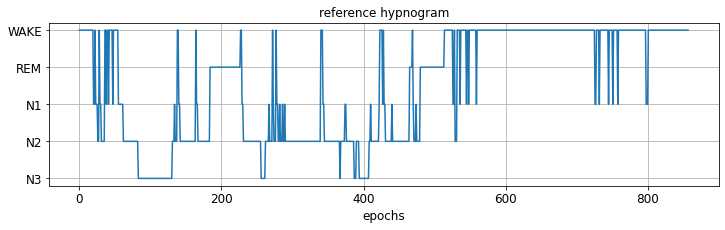

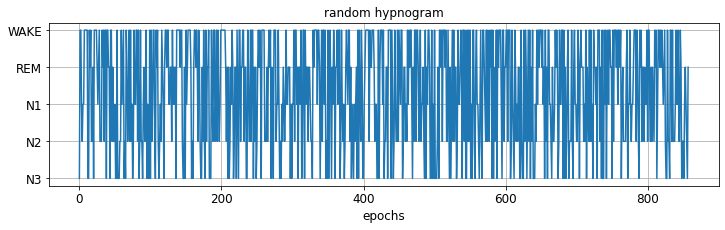

In [5]:
plot_hypnogram(ref_hypnogram, "reference hypnogram")
plot_hypnogram(rand_hypnogram, "random hypnogram")

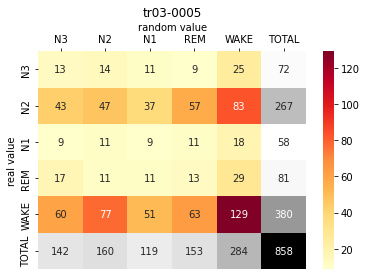

In [6]:
plot_contigency_table(ref_hypnogram, rand_hypnogram, name)

In [31]:
# Iterate over the dataset

i = 0
con_mat = np.zeros((5, 5))

for record in record_list:
    
    sleep_stages, name, _ = get_converted_sleep_stages(TRAIN_PATH+record+"-arousal.mat")
    ref_hypnogram = transform_undef(sleep_stages[0:len(sleep_stages):200*30])
    rand_hypnogram = create_random_hypno(ref_hypnogram.shape)
    
    con_mat += confusion_matrix(ref_hypnogram, rand_hypnogram)

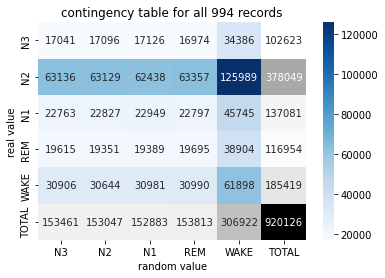

In [32]:
#plot_simple_cont_table(con_mat, "contingency table for 20 records")
labels = ["N3","N2","N1","REM","WAKE","TOTAL"]

cont_table = contingency_table(con_mat).astype("int64")
sns.heatmap(cont_table,cmap="Blues", fmt="d", annot=True,
            xticklabels=labels, mask=get_mask(cont_table))
sns.heatmap(cont_table, fmt="d", annot=True,yticklabels=labels,
            xticklabels=labels, mask=~get_mask(cont_table), cmap="binary", cbar=False)
plt.title("contingency table for all {:d} records".format(len(record_list)))
plt.ylabel("real value")
plt.xlabel("random value")
plt.show()

---

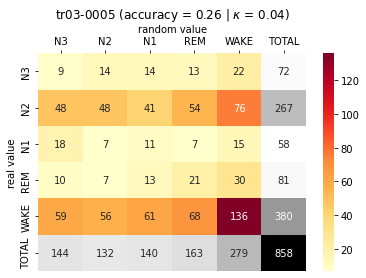

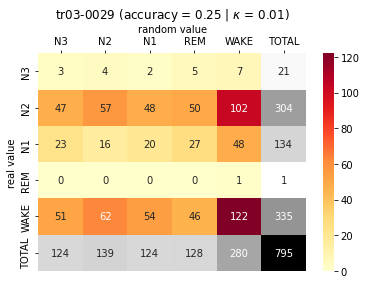

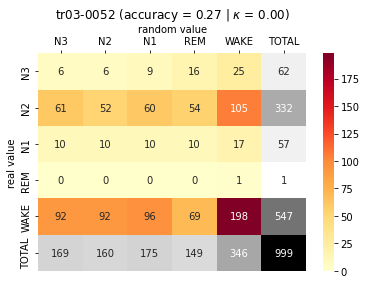

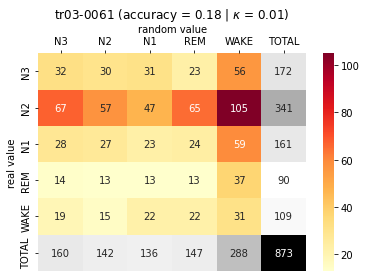

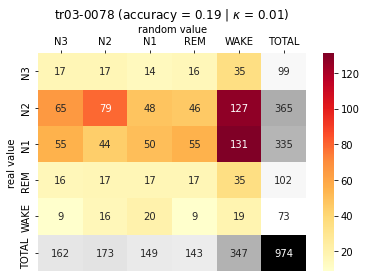

In [36]:
# Calculate the Accuracy score/kappa, will be in the title

i = 0
for record in record_list:
    
    sleep_stages, name, _ = get_converted_sleep_stages(TRAIN_PATH+record+"-arousal.mat")
    ref_hypnogram = transform_undef(sleep_stages[0:len(sleep_stages):200*30])
    rand_hypnogram = create_random_hypno(ref_hypnogram.shape)
    
    # Calculation of accuracy/kappa
    acc = accuracy_score(ref_hypnogram, rand_hypnogram)
    kappa = np.abs(cohen_kappa_score(ref_hypnogram, rand_hypnogram))
    
    title = name+" (accuracy = {:.2f} | $\kappa$ = {:.2f})".format(acc, kappa)
    plot_contigency_table(ref_hypnogram, rand_hypnogram, title)
    
    i+=1
    if i == 5:
        break

In [33]:
# Show the highest and lowest kappa

i = 0
lowest = [1, "dummy", "dummy"]
highest = [0, "dummy", "dummy"]

for record in record_list:
    
    sleep_stages, name, _ = get_converted_sleep_stages(TRAIN_PATH+record+"-arousal.mat")
    ref_hypnogram = transform_undef(sleep_stages[0:len(sleep_stages):200*30])
    rand_hypnogram = create_random_hypno(ref_hypnogram.shape)
    
    # Calculation of accuracy/kappa
    acc = accuracy_score(ref_hypnogram, rand_hypnogram)
    kappa = cohen_kappa_score(ref_hypnogram, rand_hypnogram)
    
    # Check for lowest/highest kappa
    if(kappa < lowest[0]):
        lowest.pop(2)
        lowest.pop(1)
        lowest.pop(0)
        lowest.append(kappa)
        lowest.append(ref_hypnogram)
        lowest.append(rand_hypnogram)
    if(kappa > highest[0]):
        highest.pop(2)
        highest.pop(1)
        highest.pop(0)
        highest.append(kappa)
        highest.append(ref_hypnogram)
        highest.append(rand_hypnogram)

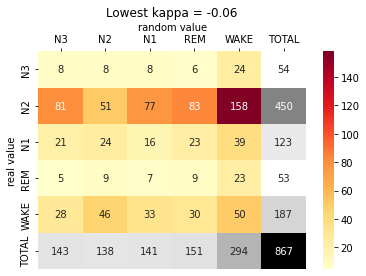

In [34]:
# lowest kappa
title = "Lowest kappa = {:.2f}".format(lowest[0])
plot_contigency_table(lowest[1], lowest[2], title)

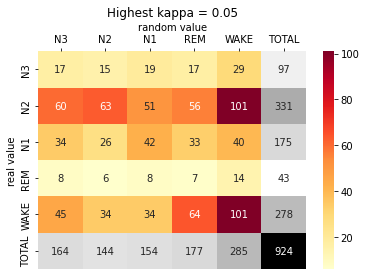

In [35]:
# highest kappa
title = "Highest kappa = {:.2f}".format(highest[0])
plot_contigency_table(highest[1], highest[2], title)

---

In [42]:
# Randomly shuffle the reference hypnogram of the respective patient

con_mat = np.zeros((5, 5))

for record in record_list:
    
    sleep_stages, name, _ = get_converted_sleep_stages(TRAIN_PATH+record+"-arousal.mat")
    ref_hypnogram = transform_undef(sleep_stages[0:len(sleep_stages):200*30])
    
    # randomly shuffle
    shuffle_hypnogram = shuffle(ref_hypnogram)
    
    tmp_cm = confusion_matrix(ref_hypnogram, shuffle_hypnogram)
    
    if len(tmp_cm) == 5:
        con_mat += tmp_cm
    elif len(tmp_cm) == 4:
        tmp_cm = np.hstack((tmp_cm, np.zeros((4, 1))))
        tmp_cm = np.vstack((tmp_cm, np.zeros(5)))
        con_mat += tmp_cm
    elif len(tmp_cm) == 3:
        tmp_cm = np.hstack((tmp_cm, np.zeros((3, 2))))
        tmp_cm = np.vstack((tmp_cm, np.zeros((5, 2)).T))
        con_mat += tmp_cm
    elif len(tmp_cm) == 2:
        tmp_cm = np.hstack((tmp_cm, np.zeros((2, 3))))
        tmp_cm = np.vstack((tmp_cm, np.zeros((5, 3)).T))
        con_mat += tmp_cm

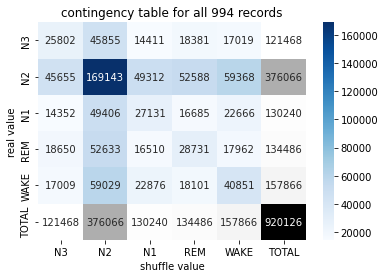

In [47]:
#plot_simple_cont_table(con_mat, "contingency table for 20 records")
labels = ["N3","N2","N1","REM","WAKE","TOTAL"]

cont_table = contingency_table(con_mat).astype("int64")
sns.heatmap(cont_table,cmap="Blues", fmt="d", annot=True,
            xticklabels=labels, mask=get_mask(cont_table))
sns.heatmap(cont_table, fmt="d", annot=True,yticklabels=labels,
            xticklabels=labels, mask=~get_mask(cont_table), cmap="binary", cbar=False)
plt.title("contingency table for all {:d} records".format(len(record_list)))
plt.ylabel("real value")
plt.xlabel("shuffle value")
plt.show()

In [44]:
# Show the highest and lowest kappa

lowest = [1, "dummy", "dummy"]
highest = [0, "dummy", "dummy"]

for record in record_list:
    
    sleep_stages, name, _ = get_converted_sleep_stages(TRAIN_PATH+record+"-arousal.mat")
    ref_hypnogram = transform_undef(sleep_stages[0:len(sleep_stages):200*30])
    shuffle_hypnogram = shuffle(ref_hypnogram)
    
    # Calculation of accuracy/kappa
    acc = accuracy_score(ref_hypnogram, shuffle_hypnogram)
    kappa = cohen_kappa_score(ref_hypnogram, shuffle_hypnogram)
    
    # Check for lowest/highest kappa
    if(kappa < lowest[0]):
        lowest.pop(2)
        lowest.pop(1)
        lowest.pop(0)
        lowest.append(kappa)
        lowest.append(ref_hypnogram)
        lowest.append(shuffle_hypnogram)
    if(kappa > highest[0]):
        highest.pop(2)
        highest.pop(1)
        highest.pop(0)
        highest.append(kappa)
        highest.append(ref_hypnogram)
        highest.append(shuffle_hypnogram)

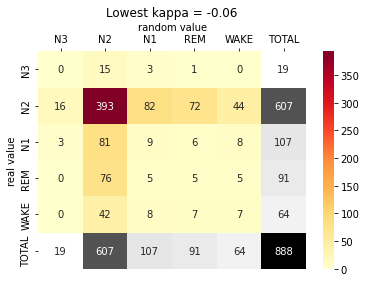

In [45]:
# lowest kappa
title = "Lowest kappa = {:.2f}".format(lowest[0])
plot_contigency_table(lowest[1], lowest[2], title)

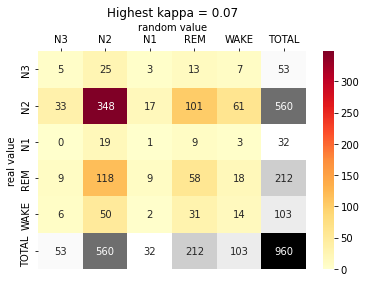

In [46]:
# highest kappa
title = "Highest kappa = {:.2f}".format(highest[0])
plot_contigency_table(highest[1], highest[2], title)